In [1]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
import seaborn as sb
#from gprofiler import GProfiler
#import loompy as lp
import rpy2.rinterface_lib.callbacks
import logging
import scrublet as scr
#from rpy2.robjects import pandas2ri
#import anndata2ri
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os              
os.environ['PYTHONHASHSEED'] = '0'

In [3]:
sc.settings.set_figure_params(dpi=100, facecolor='white')

In [4]:
%matplotlib inline

### Data Import

In [5]:
adata = sc.read_10x_mtx("/home/lugli/spuccio/Projects/LibCSC03_counts/outs/filtered_feature_bc_matrix")

In [6]:
adata.raw = adata

#### Show object shape

In [7]:
adata.shape

(13278, 32285)

#### Show genes that yield highest fraction of counts

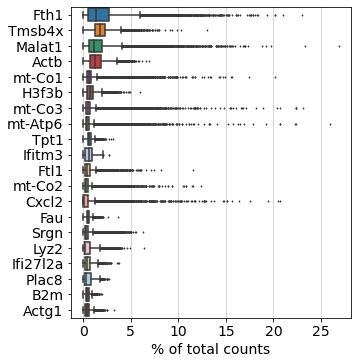

In [8]:
sc.pl.highest_expr_genes(adata,n_top=20)

#### Remove doublets

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.29
Detected doublet rate = 2.0%
Estimated detectable doublet fraction = 21.8%
Overall doublet rate:
	Expected   = 6.0%
	Estimated  = 9.2%
Elapsed time: 13.4 seconds


(<Figure size 576x216 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Observed transcriptomes'}, xlabel='Doublet score', ylabel='Prob. density'>,
        <AxesSubplot:title={'center':'Simulated doublets'}, xlabel='Doublet score', ylabel='Prob. density'>],
       dtype=object))

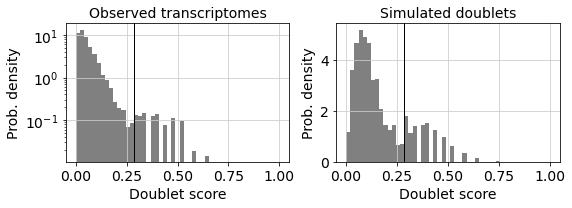

In [9]:
scrub = scr.Scrublet(adata.X,expected_doublet_rate=0.06)
adata.obs['doublet_scores'], adata.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

#### Annotate mithocondrial genes as 'mt' and calculate qc metrics

In [10]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')

In [11]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

#### Annotate disaggregation genes as 'disaggregation_score' and calculate qc metrics

In [12]:
adata.var['disaggregation_score'] = adata.var_names.str.startswith(('Atf3','Btg2','Cebpb','Cebpd','Dnaja1','Dnajb1','Dusp1','Egr1','Fos','Fosb','Hsp90ab1','Hspa1b','Hspa1a','Hspa1b','Hspa1a','Hspa1b','Hspa1a','Hspa1b','Hspa1a','Hspa8','Hspb1','Hsph1','Id3','Ier2','Jun','Junb','Jund','Mt1','Nfkbia','Nr4a1','Ppp1r15a','Socs3','Zfp36'))

In [13]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['disaggregation_score'], percent_top=None, log1p=False, inplace=True)

#### Annotate ribosomal genes as 'rp' and calculate qc metrics

In [14]:
adata.var['rb'] = adata.var_names.str.startswith('Rpl')

In [15]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['rb'], percent_top=None, log1p=False, inplace=True)

#### Plot QC with some metrics

... storing 'feature_types' as categorical


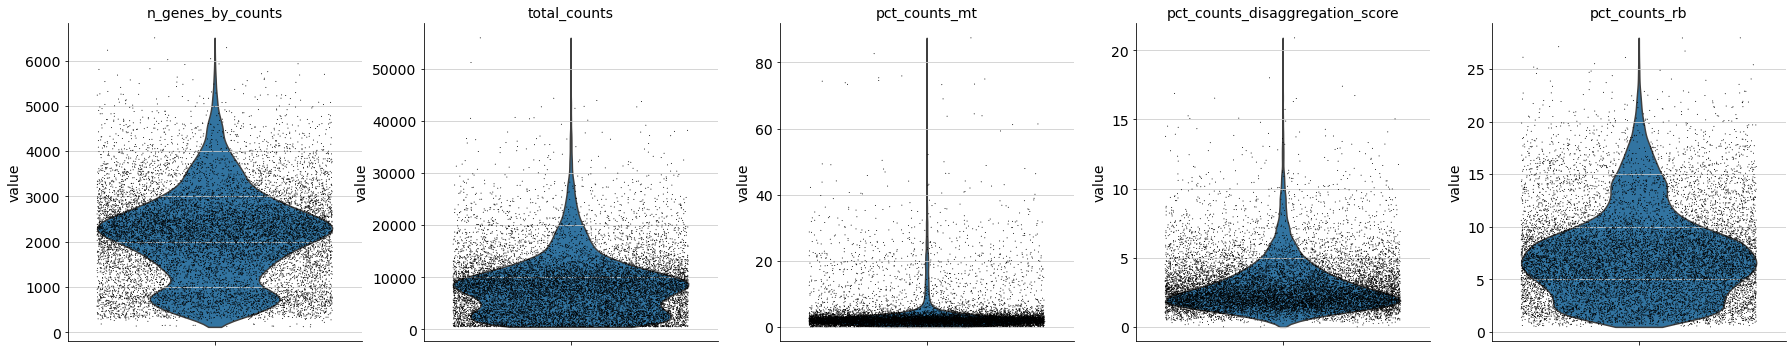

In [16]:
sc.pl.violin(adata,['n_genes_by_counts','total_counts','pct_counts_mt','pct_counts_disaggregation_score','pct_counts_rb'],jitter=0.4,multi_panel=True)

#### Plot histogram of a single variable

<AxesSubplot:xlabel='total_counts', ylabel='Density'>

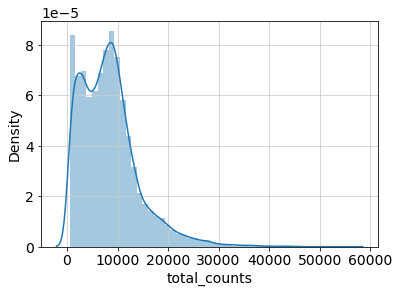

In [17]:
sb.distplot(adata.obs['total_counts'])

<AxesSubplot:xlabel='n_genes_by_counts', ylabel='Density'>

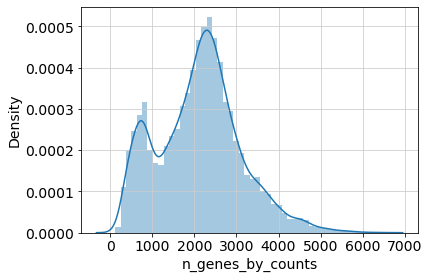

In [18]:
sb.distplot(adata.obs['n_genes_by_counts'])

<AxesSubplot:xlabel='pct_counts_mt', ylabel='Density'>

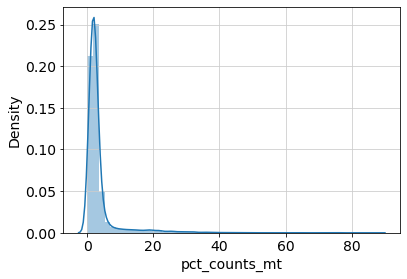

In [19]:
sb.distplot(adata.obs['pct_counts_mt'])

<AxesSubplot:xlabel='pct_counts_disaggregation_score', ylabel='Density'>

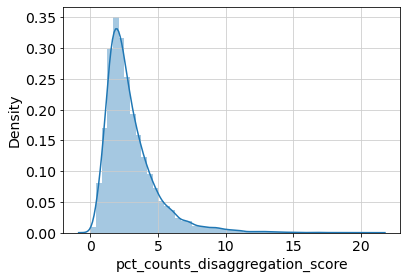

In [20]:
sb.distplot(adata.obs['pct_counts_disaggregation_score'])

<AxesSubplot:xlabel='pct_counts_rb', ylabel='Density'>

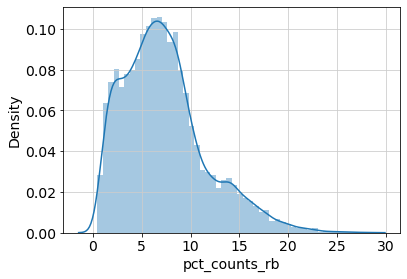

In [21]:
sb.distplot(adata.obs['pct_counts_rb'])

#### Plot a scatter plot of QC metrics

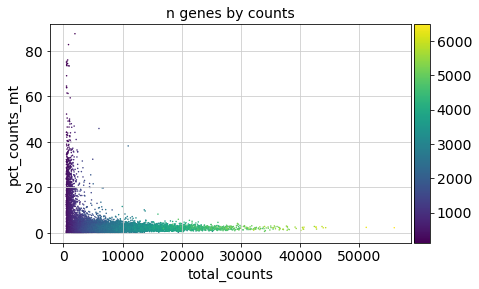

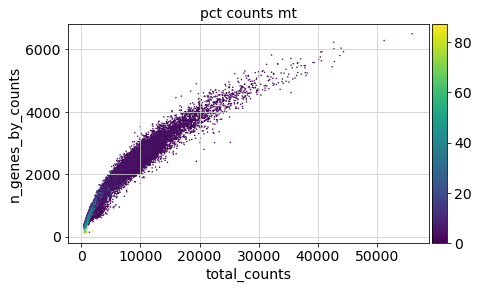

In [22]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt', color = 'n_genes_by_counts')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color = 'pct_counts_mt')

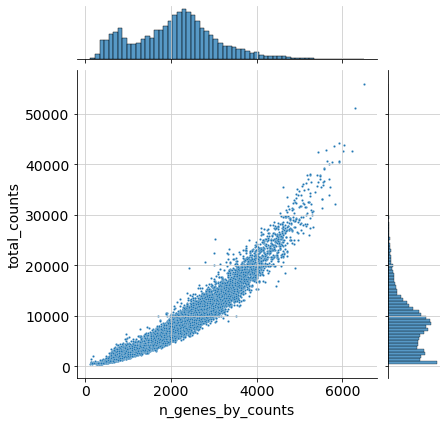

In [23]:
sb.jointplot(x="n_genes_by_counts",y="total_counts",data=adata.obs, kind="scatter", s=5)

#### Basic filtering

In [24]:
sc.pp.filter_cells(adata,min_genes=200)
sc.pp.filter_genes(adata,min_cells=3)

In [25]:
adata.shape

(13260, 18429)

#### Advanced Filtering

In [26]:
tmp = adata
tmp = tmp[tmp.obs.n_genes_by_counts < 4500, :]
tmp = tmp[tmp.obs.total_counts > 500, :]
tmp = tmp[tmp.obs.pct_counts_mt < 5, :]
tmp = tmp[tmp.obs.pct_counts_rb < 13, :]
tmp = tmp[tmp.obs.pct_counts_rb > 2, :]
tmp = tmp[tmp.obs.pct_counts_disaggregation_score < 5, :]

#### Check filtering 

In [27]:
tmp.shape

(8202, 18429)

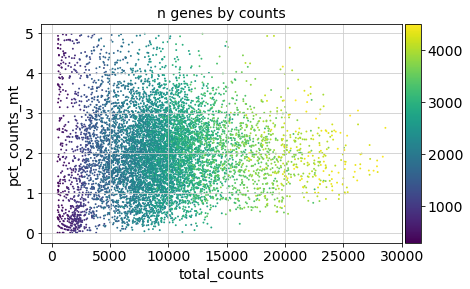

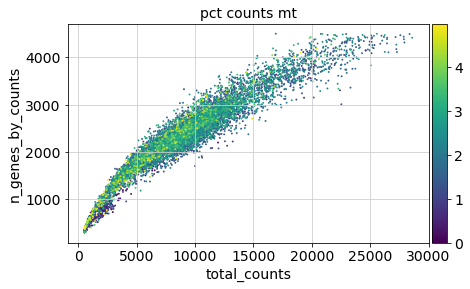

In [28]:
sc.pl.scatter(tmp, x='total_counts', y='pct_counts_mt', color = 'n_genes_by_counts')
sc.pl.scatter(tmp, x='total_counts', y='n_genes_by_counts', color = 'pct_counts_mt')

<AxesSubplot:xlabel='pct_counts_rb', ylabel='Density'>

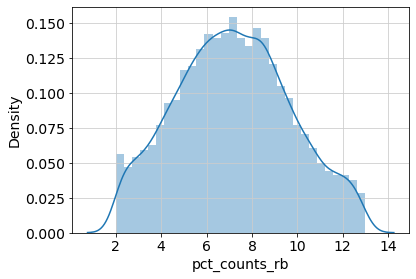

In [29]:
sb.distplot(tmp.obs['pct_counts_rb'])

#### Save object

In [30]:
adata = tmp

In [31]:
adata.layers['raw_counts'] = adata.X

In [32]:
adata.obs['SampleID'] = "Mouse5NT"
adata.obs['Treatment'] = "NotTreated"
adata.obs['MouseID'] = "5"

In [33]:
adata.write("/home/lugli/spuccio/Projects/SP025_NaClTcell/singlecell/Analysis/Mouse5QC.h5ad")

... storing 'SampleID' as categorical
... storing 'Treatment' as categorical
... storing 'MouseID' as categorical
... storing 'feature_types' as categorical


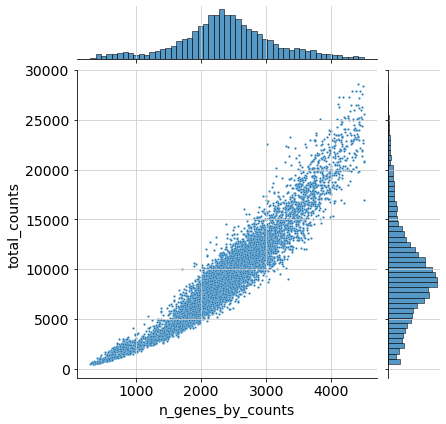

In [34]:
sb.jointplot(x="n_genes_by_counts",y="total_counts",data=tmp.obs, kind="scatter", s=5)